# 01 Classification with scikit-learn 
## Introduction
In this exercise, we consider the task of classifying data comprising two classes using __supervised learning__. In supervised learning a model is trained (that is, fitted) to data consisting of (ideally) unambiguously labeled data. The data consists of an array of data elements called __feature vectors__. 
A feature vector could be, for example, a matrix of pixel values of a gray scale image or 3 matrices of pixel values for an RGB image. Or it could be financial data on a bank customer and the goal could be to classify customers into different credit risk categories based on historical credit  risk data.

The task is to build a __binary__ classifier in which one class is labeled with the __target__ $t = 1$ while the other is labeled with the target $t = 0$ and each object to be classified is characterized by data $\mathbf{x}$. (Note, often $t$ is represented by the symbol $y$.) That is, the data set is $\{(t_i, \mathbf{x}_i \}$. The fundamental assumption of almost all machine learning models is that the data are presumed to be drawn from a joint probability density function (or, for discrete data, probability mass function), $p(t, \mathbf{x})$.

We shall use the machine learning model 

$$f(\mathbf{x}, \theta) = \mbox{logistic}(\,\mathbf{b}_1 + \mathbf{w}_1 \, \mbox{relu}(\mathbf{b}_0 + \mathbf{w}_0 \, \mathbf{x}) \, ),$$

where $\mathbf{b}$ and $\mathbf{w}$ (the biases and weights) are the parameters $\theta$ of the model and $\mbox{logistic}(x) = 1/(1 + \exp(-x))$ (sigmoid) and $\mbox{relu}(x)$ are functions applied to every element of their tensor argument (i.e., applied element-wise). The function
$\mbox{relu}(x)$ is defined by

\begin{align*}
\mbox{relu}(x) & = \begin{cases}
    x, & \text{if } x \gt 0\\
    0              & \text{otherwise}.
\end{cases}
\end{align*}

See 01_classification.ipynb for more details.

In [1]:
# operating system and system modules
import os, sys

# handles dataframes (basically, tables)
import pandas as pd

# efficient array manipulations
import numpy as np

# scikit-learn modules
from sklearn.model_selection import train_test_split

# Multi-layer perceptron, which is another name for a fully-connected
# feed-forward neural network.
from sklearn.neural_network import MLPClassifier

# ROC curve and Area Under the (ROC) Curve (AUC), which is a measure
# of classification quality.
from sklearn.metrics import roc_curve, auc

# high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt

# dumping and loading objects from/to memory
import joblib as jb

%matplotlib inline

In [2]:
# update fonts
FONTSIZE = 18
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}

# this runs LaTex to give you publication quality plots, but
# it slows down plotting. comment out while in development mode
#mp.rc('text', usetex=True) 

mp.rc('font', **font)

Tips:

  1. UNDO edits: command Z
  1. RUN cell: shift return 
  

### Load and plot data 


In [3]:
data = jb.load('data_01.db')
data[:10]

,target,x,y
0,0.0,-1.462965,2.426415
1,0.0,0.316226,-1.726901
2,0.0,-2.716621,0.390152
3,0.0,0.835977,-2.415027
4,0.0,1.594806,-2.201238
5,0.0,2.251994,-0.009178
6,1.0,1.117939,-0.094264
7,0.0,-2.651078,-1.876610
8,1.0,0.561020,-0.137487
9,0.0,-2.327774,1.308989


In [4]:
def plot_data(df, N=4000):
    sig = df[df.target > 0.5][:N]
    bkg = df[df.target < 0.5][:N]
    
    # create an empty figure
    fig = plt.figure(figsize=(5, 5))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)
    ax.set_xlabel('$x$', fontsize=FONTSIZE)
    ax.set_ylabel('$y$', fontsize=FONTSIZE)
    
    ax.scatter(sig['x'], sig['y'], c='b', s=1, alpha=0.5, label='$t = 1$')
    ax.scatter(bkg['x'], bkg['y'], c='r', s=1, alpha=0.5, label='$t = 0$')

    ax.grid(True, which="both", linestyle='-')
    ax.legend(loc='upper right')

    plt.show()

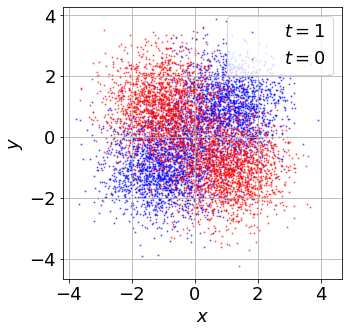

In [5]:
plot_data(data)

### Train, validation, and test sets
There is some confusion in terminology regarding validation and test samples (or sets). We shall adhere to the defintions given here https://machinelearningmastery.com/difference-test-validation-datasets/):
   
  * __Training Dataset__: The sample of data used to fit the model.
  * __Validation Dataset__: The sample of data used to decide 1) whether the fit is reasonable (e.g., the model has not been overfitted), 2) decide which of several models is the best and 3) tune model hyperparameters.
  * __Test Dataset__: The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.

The validation set will be some small fraction of the training set and will be used to decide when to stop the training.

In [6]:
# Fraction of the data assigned as test data
fraction = 0.20
# Split data into a part for training and a part for testing
train_data, test_data = train_test_split(data, test_size=fraction)

# Split the training data into a part for training (fitting) and
# a part for validating the training.
fraction = 0.125
train_data, valid_data = train_test_split(train_data, test_size=fraction)

print('train set size:        %6d' % train_data.shape[0])
print('validation set size:   %6d' % valid_data.shape[0])
print('test set size:         %6d' % test_data.shape[0])

train set size:         42000
validation set size:     6000
test set size:          12000


In [7]:
def split_t_x(df, inputs=['x', 'y']):
    # change from pandas dataframe format to a numpy 
    # array of the specified types
    t = np.array(df['target']).astype(np.long)
    x = np.array(df[inputs]).astype(np.float32)
    return (t, x)

train_t, train_x = split_t_x(train_data)
valid_t, valid_x = split_t_x(valid_data)
test_t,  test_x  = split_t_x(test_data)

### Create model

The model has structure (2,50,1), that is, 2 inputs $(x, y)$, 50 
nodes in layer 0 and one node (the output node) in layer 1.

$$f(\mathbf{x}, \theta) = \mbox{logistic}(\,b_1 + \mathbf{w}_1 \, \mbox{relu}(\mathbf{b}_0 + \mathbf{w}_0 \, \mathbf{x}) \, ).$$

In [8]:
model = MLPClassifier(hidden_layer_sizes=(50,), 
                      max_iter=500, 
                      alpha=1e-2,
                      solver='adam', 
                      verbose=0, 
                      tol=1e-6, 
                      warm_start=False,
                      random_state=1)

### Train classifier

In [10]:
# train, that is, fit
model.fit(train_x, train_t)

print("Training set score: %8.3f" % model.score(train_x, train_t))      
print("Test set score:     %8.3f" % model.score(test_x,  test_t))

# save fitted model
filename = '01_classification_sklearn_model.pkl'
print("save to %s" % filename)
jb.dump(model, filename)

Training set score:    0.772
Test set score:        0.769
save to 01_classification_sklearn_model.pkl


['01_classification_sklearn_model.pkl']

### Plot loss curve vs. epochs

In [11]:
def plot_average_loss(model, ftsize=FONTSIZE):

    y    = model.loss_curve_
    x    = np.array(range(len(y)))+1

    xmin = 0
    xmax = len(x)
    ymin = 0.8*min(y)
    ymax = 1.2*max(y)
    
    # create an empty figure
    fig = plt.figure(figsize=(5, 5))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.plot(x, y, 'b-', lw=2)
    ax.set_xlabel('epoch', fontsize=FONTSIZE)
    ax.set_ylabel('average loss', fontsize=FONTSIZE)
    ax.set_yscale('log')
    ax.grid(True, which="both", linestyle='-')
    
    plt.savefig('01_classification_sklearn_average_loss.png')
    plt.show();

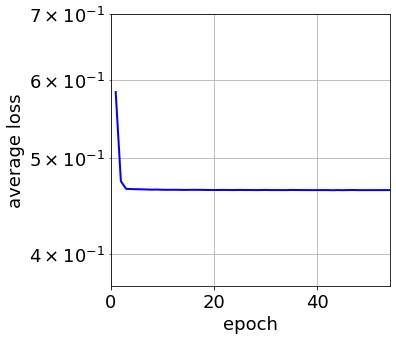

In [12]:
plot_average_loss(model)

### Compute $p(1|x)$ from the model

In [16]:
# predict_proba returns an array of shape (n-rows, number-of-classes)
# containing the predicted probabilities of each class.
# here we pick the probability p(1|x) for the class with t == 1
p  = np.array([p1 for p0, p1 in model.predict_proba(test_x)])

In [17]:
def plot_distributions(p, t):
    ps = p[t > 0.5] # probabilities for class with t == 1
    pb = p[t < 0.5] # probabilities for class with t == 0
    
    # create an empty figure
    fig = plt.figure(figsize=(5, 5))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)
    ax.set_xlim(0, 1)
    
    ax.hist(ps, bins=50, color='b',
            histtype='stepfilled',
            alpha=0.5, label='$t = 1$')
    
    ax.hist(pb, bins=50, color='r',
            histtype='stepfilled',
            alpha=0.5, label='$t = 0$')
    
    ax.set_xlabel('$p(1|x)$', fontsize=FONTSIZE)
    
    ax.legend(loc='upper right')
    
    plt.savefig('01_classification_sklearn_dist.png')
    plt.show()

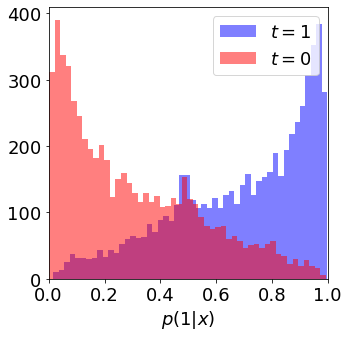

In [18]:
plot_distributions(p, test_t)

### Plot Receiver Operating Characteristic (ROC) curve

In [21]:
def plot_roc_curve(p, t):
    bad, good, _ = roc_curve(t, p)
    roc_auc = auc(bad, good)
    
    fig = plt.figure(figsize=(5, 5))
    fig.tight_layout()
    ax  = fig.add_subplot(1,1,1)
    
    ax.plot(bad, good, color='red',
            lw=1, label='ROC curve, AUC = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel(r'fraction$(t=0)$', fontsize=18)
    ax.set_ylabel(r'fraction$(t=1)$', fontsize=18)
    ax.legend(loc="lower right", fontsize=14)
    
    plt.savefig('01_classification_sklearn_roc.png')
    plt.show()

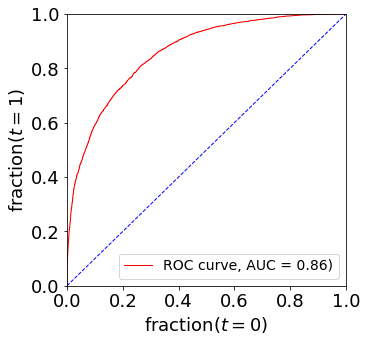

In [22]:
plot_roc_curve(p, test_t)